## Prerequisites

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns

In [2]:
def display_data(fake_data, train_data):
    fake_data = pd.DataFrame(fake_data)
    fake_data.head()

    train_data = pd.DataFrame(train_data)
    train_data.head()

    fake_data["label"] = 1
    train_data["label"] = 0
    
    data = pd.concat([fake_data, train_data])
    data.head()

    sns.pairplot(data, hue='label')
    
def norm(x, mu, theta):
    return (x - mu)/theta

def denorm(x, mu, theta):
    return x * theta + mu

## Observation of data

Let's see how our data look like

In [3]:
df = pd.read_csv('data/train.csv', header=None)
train_data = np.array(df.drop(labels=0, axis=1))
data_dim = train_data.shape[1]

In [4]:
def augmentor(train_data, size):
    X = train_data ** 0.25

    mu = np.mean(X, axis=0)
    cov = np.cov(X.T)
    
    generated = np.random.multivariate_normal(mu, cov, size) ** 4
    
    return generated

In [79]:
def generate_data(train_data, Z):
    X = train_data ** 0.25

    mu = np.mean(X, axis=0)
    
    
    cov = np.cov(X.T)
    
    B = np.linalg.cholesky(cov)
    
    
    generated = (mu + np.dot(Z, B.T)) ** 4
    
    return generated

In [80]:
size = train_data.shape[0]

mu_Z = np.zeros(train_data.shape[1])
cov_Z = np.eye(train_data.shape[1])
Z = np.random.multivariate_normal(mu_Z, cov_Z, size)
Z

array([[-0.46118239,  0.77646344,  2.62953334, -0.25766064],
       [ 0.11621873,  1.76761023, -0.90088782, -0.30336695],
       [-0.43628981, -1.55935869, -0.63843491,  0.6579848 ],
       ...,
       [ 2.62032204,  0.04447192, -1.58268687, -2.62732979],
       [-1.97720378,  1.67881802, -2.22534324,  0.91941997],
       [ 1.2490657 ,  0.0923899 ,  0.02056776, -0.07621103]])

In [81]:
generated = generate_data(train_data, Z)
generated.shape

(746, 4)

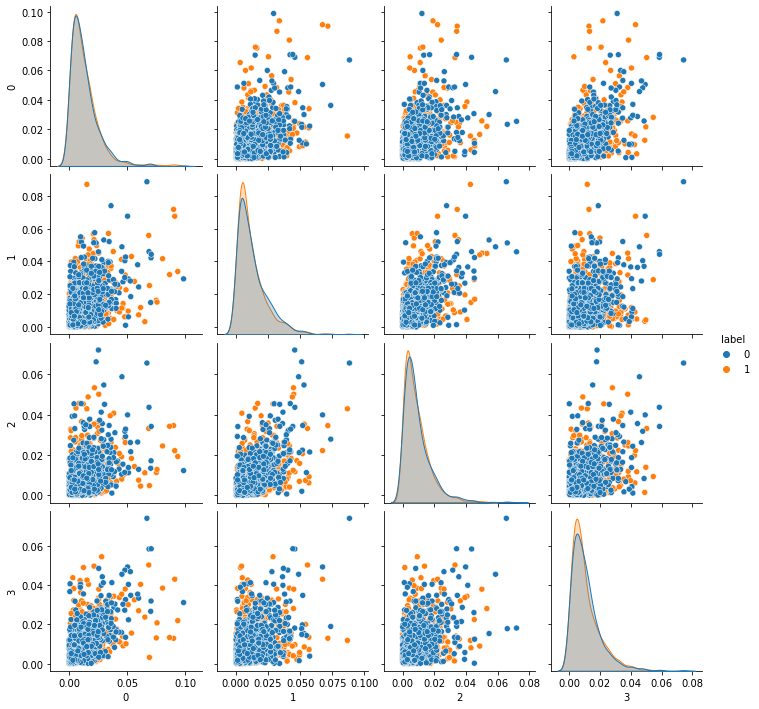

In [82]:
display_data(generated, train_data)

### Definition of GAN models

In [6]:
import torch
import torch.nn as nn

if torch.cuda.is_available():
    print('You use GPU !')
    device = torch.device('cuda')
else:
    print('You use CPU !')
    device = torch.device('cpu')

You use GPU !


In [7]:
# Generative model
def make_generator(noise_dim):
    return nn.Sequential(
        nn.Linear(in_features=noise_dim, out_features=128),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        
        nn.Linear(in_features=128, out_features=32),
        nn.BatchNorm1d(32),
        nn.ReLU(),
        
        nn.Linear(in_features=32, out_features=data_dim),
        nn.ReLU(),
    )


# Discriminative model
def make_discriminator():
    return nn.Sequential(
        nn.Linear(in_features=data_dim, out_features=64),
        nn.BatchNorm1d(64),
        nn.Sigmoid(),
        
        nn.Linear(in_features=64, out_features=16),
        nn.BatchNorm1d(16),
        nn.Sigmoid(),
        
        
        nn.Linear(in_features=16, out_features=2)
    )

## Training

Split dataset into training data and evaluation data

In [8]:
n_augmented_data = 50000
augmented = augmentor(train_data, n_augmented_data)
augmented_data = np.concatenate([augmented, train_data])

In [9]:
X = torch.tensor(augmented_data , dtype=torch.float).to(device) ** 0.25
mu = X.mean(dim=0)
theta = torch.sqrt(((X - mu)**2).mean(dim=0))
X = norm(X, mu, theta)

eval_rate = 0.
eval_index = int(X.shape[0] * (1 - eval_rate))
X_train = X[0: eval_index]
X_eval = X[eval_index:]

batch_size = 64

X_train_loader = torch.utils.data.DataLoader(X_train, batch_size, shuffle=True)
# X_eval_loader = torch.utils.data.DataLoader(X_eval, batch_size, shuffle=True)

We choose Adam Optimizer ($\beta_1 = 0.9$, $\beta_2 = 0.999$)

In [10]:
noise_dim = 8
generator = make_generator(noise_dim=noise_dim).to(device)
discriminator = make_discriminator().to(device)


num_epochs = 20
lr = 0.001
gen_optimizer = torch.optim.Adam(generator.parameters(), lr=lr)
disc_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr)

criterion = torch.nn.CrossEntropyLoss()

In [11]:
for i in tqdm(range(num_epochs)):
    disc_losses = []
    gen_losses = []
    for true_data in X_train_loader:
        #### DISCRIMINATOR OPTMIZATION ####
        n_data = true_data.shape[0]
        
        discriminator.train() # Unfreeze parameters of the discriminator
        generator.eval() # Freeze parameters of the generator
        
        disc_optimizer.zero_grad()
        
        true_x = true_data.to(device) # true data from the training dataset
        noise = torch.randn(n_data, noise_dim).to(device)
        fake_x = generator(noise).detach() # fake data from the noise distribution ~ N(0, 1)

        x = torch.cat([true_x, fake_x]) # Gather true and fake data
        
        
        true_y = torch.ones((n_data,), dtype=torch.long).to(device) # target 1 for true data
        fake_y = torch.zeros((n_data,), dtype=torch.long).to(device) # target 0 for fake data
        
        y = torch.cat([true_y, fake_y]) # Gather true and fake targets
        
        
        
        output = discriminator(x)
        
        disc_loss = criterion(output, y) # Penalize Discriminator for failing to distinguish fake data from true data
        disc_losses.append(disc_loss.item())
        
        disc_loss.backward()
        
        
        disc_optimizer.step() # Optimize Discriminator
        
        
        
        ### GENERATOR OPTIMIZATION ###
        n_data = true_data.shape[0] * 2
    
        discriminator.eval() # Freeze parameters of the discriminator
        generator.train() # Unfreeze parameters of the generator

        gen_optimizer.zero_grad()
        
        
        noise = torch.randn(n_data, noise_dim).to(device)
        fake_x = generator(noise) # fake data from the noise distribution ~ N(0, 1)
        
        true_y = torch.ones((n_data,), dtype=torch.long).to(device) # target 1 for true data
        
        output = discriminator(fake_x)
        
        gen_loss = criterion(output, true_y) # Penalize Generator for failing to fool the discriminator
        gen_losses.append(gen_loss.item())
        
        gen_loss.backward()
        

        gen_optimizer.step() # Optimize Generator  
    
    
    disc_loss = np.mean(disc_losses)
    gen_loss = np.mean(gen_losses)
    
    

100%|██████████| 20/20 [02:19<00:00,  6.97s/it]


In [ ]:
discriminator.eval()
generator.eval()

In [22]:
discriminator(generator(torch.randn(batch_size*4, noise_dim).to(device))).argmax(dim=1)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')

In [18]:
discriminator(X).argmax(dim=1)[:300]

tensor([1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,
        1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1,
        0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1,
        1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
        1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
        1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1,
        1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,
        1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1,
        1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
        0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1,
        1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0,
        1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1,

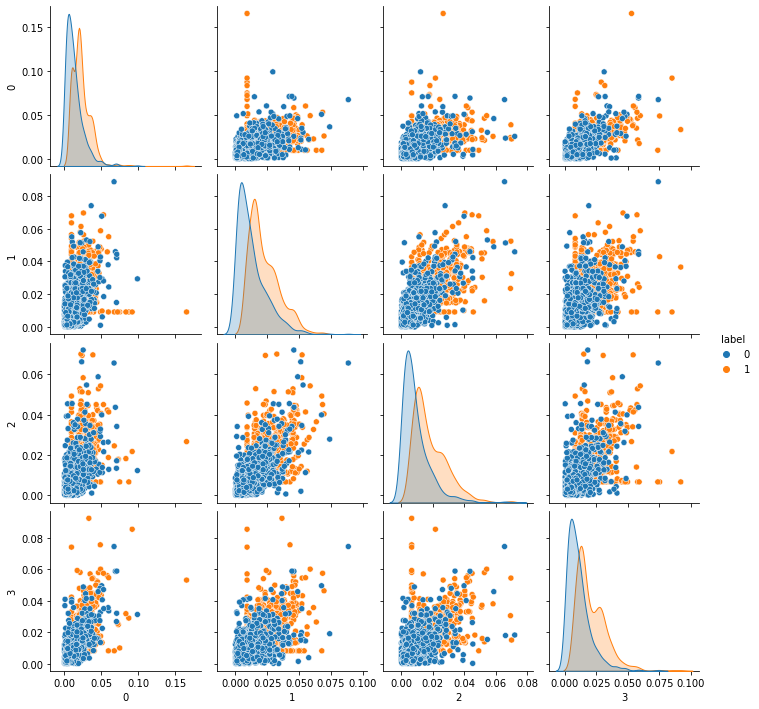

In [13]:
fake_data = generator(torch.randn(train_data.shape[0], noise_dim).to(device))
fake_data = denorm(fake_data, mu, theta) ** 4
fake_data = fake_data.detach().cpu().numpy()

display_data(fake_data, train_data)